In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd

import nbimporter
import sys
sys.path.append('../')

from src.ees_external_condition import ExternalCondition

# 年間の外気温度から暖冷房期間を設定する

Sim Heat で実施している暖冷房期間の設定をトレースする。

## 1. Sim Heat における暖冷房期間

|   | 参照地点 | 暖房開始 | 暖房終了 | 冷房開始 | 冷房終了 |
| --- | --- | --- | --- | --- | --- |
| Ia | Ia北見086 | 9月24日 | 6月7日 | 7月10日 | 8月31日 |
| Ib | Ib岩見沢059 | 9月26日 | 6月4日 | 7月15日 | 8月31日 |
| II | II盛岡224 | 9月30日 | 5月31日 | 7月10日 | 8月31日 |
| III | III長野393 | 10月1日 | 5月30日 | 7月10日 | 8月31日 |
| IVa | IVa宇都宮333 | 10月10日 | 5月15日 | 7月6日 | 8月31日 |
| IVb | IVb岡山615 | 11月4日 | 4月21日 | 5月30日 | 9月23日 |
| V | V宮崎794 | 11月26日 | 3月27日 | 5月15日 | 10月13日 |
| VI | VI那覇831 | － | － | 3月25日 | 12月14日 |


## 2. 基本的な操作に関する関数

### 1) 通算日の取得

特定の月日が1月1日から何日目にあたるのかを計算する。   
1/1 = 0, 1/2 = 1......12/31 = 364 とする。

In [2]:
def get_n_days(month, day):
    d1 = datetime.datetime(year = 2015, month = 1, day = 1)
    d2 = datetime.datetime(year = 2015, month = month, day = day)
    return (d2-d1).days

#### Example

In [3]:
get_n_days(1,1), get_n_days(2,1), get_n_days(3,1), get_n_days(4,1), get_n_days(5,1), get_n_days(6,1), \
get_n_days(7,1), get_n_days(8,1), get_n_days(9,1), get_n_days(10,1), get_n_days(11,1), get_n_days(12,1)

(0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334)

### 2) 通算日から月日の取得

In [4]:
def get_month_and_day(nday):
    d1 = datetime.datetime(year = 2015, month = 1, day = 1)
    d2 = d1 + datetime.timedelta(days = nday)
    return d2.month, d2.day

In [5]:
def get_month_and_day_as_string(nday):
    m, d = get_month_and_day(nday)
    return str(m) + '月' + str(d) + '日'

#### Example

In [6]:
[get_month_and_day(d) for d in [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]]

[(1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1)]

In [7]:
[get_month_and_day_as_string(d) for d in [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]]

['1月1日',
 '2月1日',
 '3月1日',
 '4月1日',
 '5月1日',
 '6月1日',
 '7月1日',
 '8月1日',
 '9月1日',
 '10月1日',
 '11月1日',
 '12月1日']

### 3) 暖冷房期間の開始・終了Indexの取得

暖房期間

In [8]:
def calc_start_and_end_day_for_heating_period(d):
    
    def calc_start_day(d):
        for i in range(len(d)):
            if (d[i-1] == 'M' and d[i] == 'H') or (d[i-1] == 'C' and d[i] == 'H'):
                return i
        raise ValueError
    
    def calc_end_day(d):
        for i in range(len(d)):
            if (d[i-1] == 'H' and d[i] == 'M') or (d[i-1] == 'H' and d[i] == 'C'):
                return i - 1 if i != 0 else len(d) - 1
        raise ValueError
    
    return calc_start_day(d), calc_end_day(d)

冷房期間

In [9]:
def calc_start_and_end_day_for_cooling_period(d):
    
    def calc_start_day(d):
        for i in range(len(d)):
            if (d[i-1] == 'M' and d[i] == 'C') or (d[i-1] == 'H' and d[i] == 'C'):
                return i
        raise ValueError
    
    def calc_end_day(d):
        for i in range(len(d)):
            if (d[i-1] == 'C' and d[i] == 'M') or (d[i-1] == 'C' and d[i] == 'H'):
                return i - 1 if i != 0 else len(d) - 1
        raise ValueError
    
    return calc_start_day(d), calc_end_day(d)

## 3. 外気温度の読み込み

外気条件CSV

In [10]:
PATH = '../data/ees_external_condition.csv'

region を指定して温度リスト(8760行)を取得する関数

In [11]:
def get_temperature(region):
    ec = ExternalCondition(path = PATH, region = region, reading_order = True, error_print = False)
    return [r.T.C for r in ec.get_air_row()]

全地域の温度リスト(8760行)を取得

In [12]:
temps = [get_temperature(r) for r in ['region1', 'region2', 'region3', 'region4', 'region5', 'region6', 'region7', 'region8']]

データの確認(最初の5行)

In [13]:
for i, r in enumerate(['region1', 'region2', 'region3', 'region4', 'region5', 'region6', 'region7', 'region8']):
    print(r)
    print([temps[i][j] for j in range(6)])

region1
[-12.399999999999977, -13.0, -14.199999999999989, -15.0, -16.19999999999999, -16.69999999999999]
region2
[-7.0, -6.899999999999977, -6.699999999999989, -6.899999999999977, -6.899999999999977, -5.399999999999977]
region3
[0.19999999999998863, 0.10000000000002274, -0.39999999999997726, -0.39999999999997726, -0.8999999999999773, -1.1999999999999886]
region4
[-1.5, -1.3999999999999773, -1.6999999999999886, -1.5, -1.8000000000000114, -1.1999999999999886]
region5
[-0.5, -0.8999999999999773, -2.0, -2.8000000000000114, -4.0, -4.199999999999989]
region6
[2.3000000000000114, 2.6000000000000227, 2.8999999999999773, 2.8000000000000114, 2.3999999999999773, 2.3999999999999773]
region7
[4.300000000000011, 3.5, 2.8999999999999773, 2.6999999999999886, 1.8000000000000114, 1.3000000000000114]
region8
[19.100000000000023, 19.100000000000023, 19.69999999999999, 19.899999999999977, 20.30000000000001, 19.399999999999977]


## 4. 日平均気温の計算

日平均気温を計算する関数

In [14]:
def get_average_temp(temp):
    return [sum(temp[i*24:i*24+24])/24 for i in range(365)]

全地域の日平均気温を取得

In [15]:
average_temps = [get_average_temp(temp) for temp in temps]

## 5. 日最高気温の計算

日最高気温を計算する関数

In [16]:
def get_maximum_temp(temp):
    return [max(temp[i*24:i*24+24]) for i in range(365)]

全地域の日最高気温を取得

In [17]:
maximum_temps = [get_maximum_temp(temp) for temp in temps]

## 6. 日平均・最高気温をsin関数で近似(フーリエ変換を使用)

フーリエ変換を用いてsin関数で近似した値を計算する関数

In [18]:
def make_curve(data):
    
    def get_value(dft, n):
        return np.array([(dft[n].real * np.cos(2 * np.pi / 365 * i * n) \
                          - dft[n].imag * np.sin(2 * np.pi / 365 * i * n) ) / 365 for i in range(365)])

    dft = np.fft.fft(data)
    
    return get_value(dft, 0) + get_value(dft, 1) * 2

サイン波にもとづく値の計算

In [19]:
average_temps_sin = [make_curve(average_temp) for average_temp in average_temps]
maximum_temps_sin = [make_curve(maximum_temp) for maximum_temp in maximum_temps]

値の確認

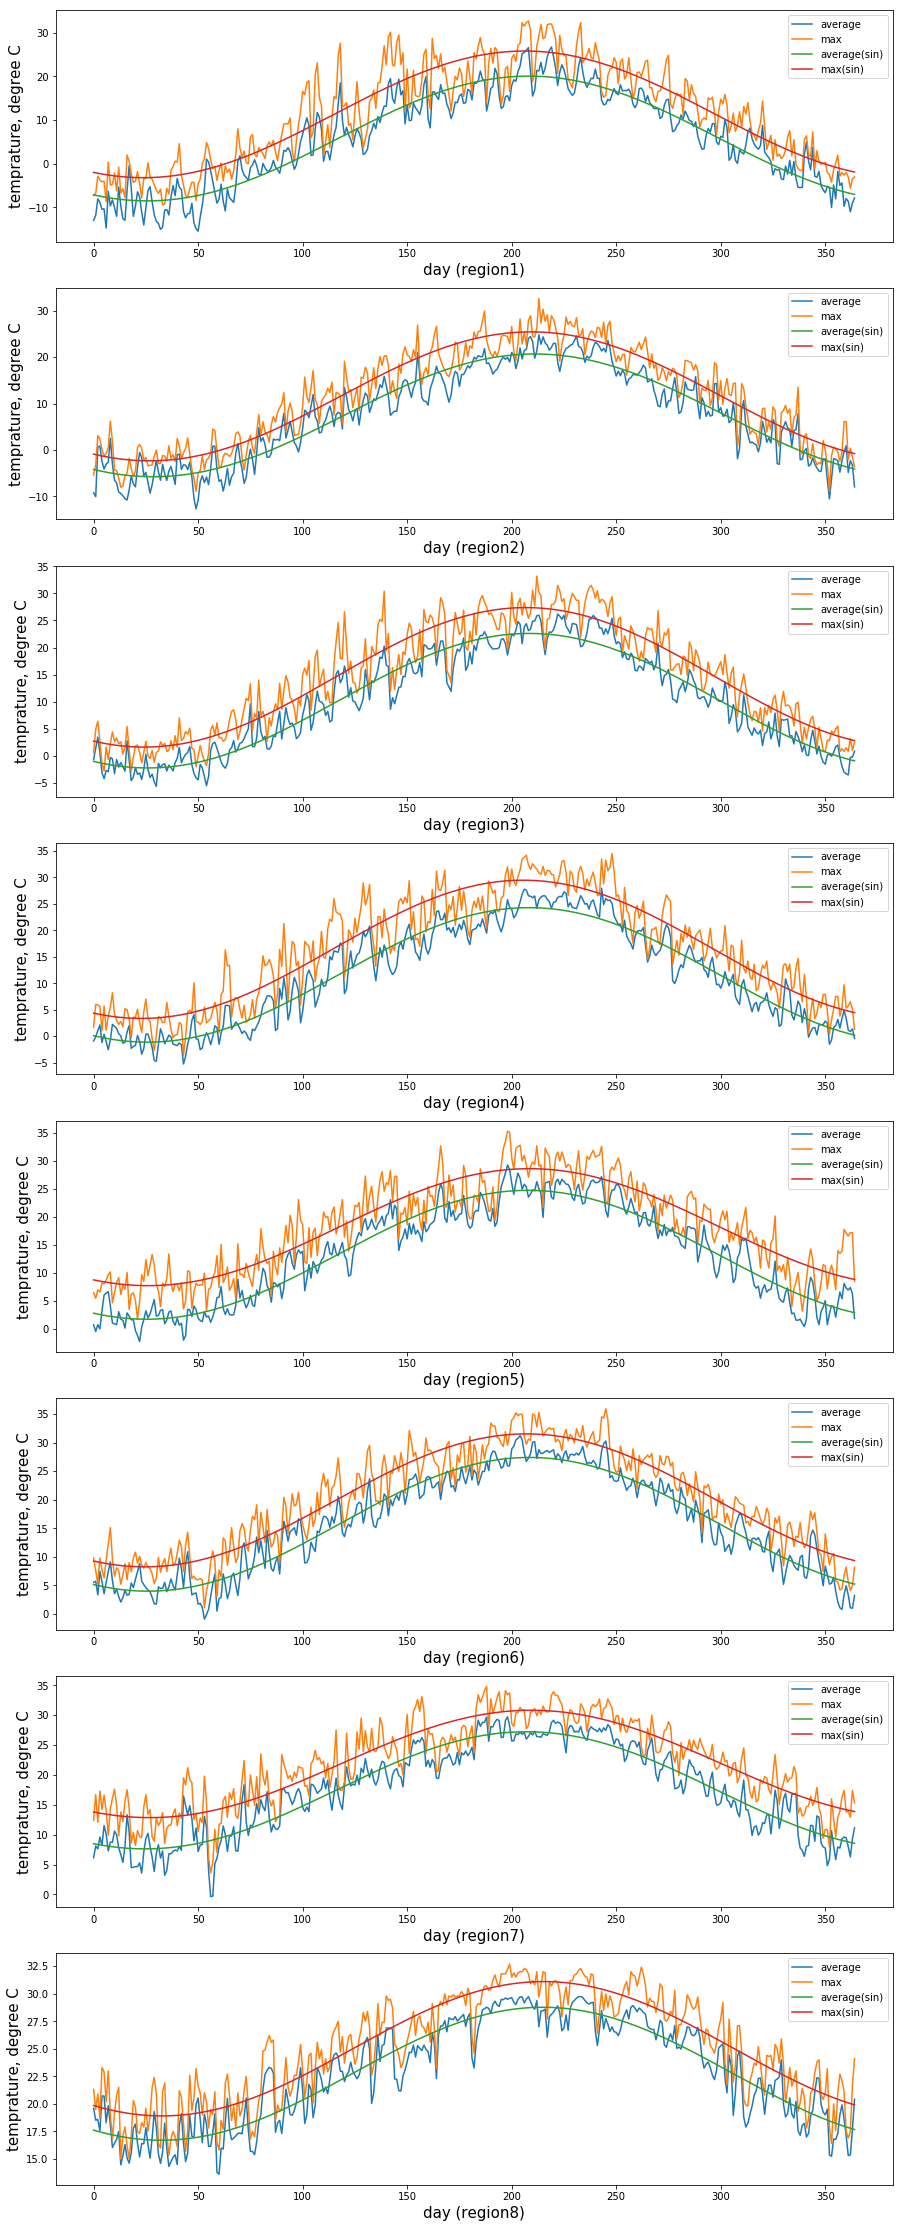

In [20]:
fig = plt.figure(figsize = (15,5*8))
for i, r in enumerate(['region1', 'region2', 'region3', 'region4', 'region5', 'region6', 'region7', 'region8']):
    ax = fig.add_subplot(8,1,i+1)
    ax.plot(range(365), average_temps[i], label = 'average')
    ax.plot(range(365), maximum_temps[i], label = 'max')
    ax.plot(range(365), average_temps_sin[i], label = 'average(sin)')
    ax.plot(range(365), maximum_temps_sin[i], label = 'max(sin)')
    ax.set_xlabel('day (' + r + ')', fontsize = 15)
    ax.set_ylabel('temprature, degree C', fontsize = 15)
    plt.legend()

## 7. 暖冷房期間の仮決め

sin波で近似したデータについて
- 日平均気温が15℃以下となる期間を暖房期間とする。  
- 日最高気温が24℃以上となる期間を冷房期間とする。  
- 重複する期間が生じた場合は暖房期とする。
- どちらにも当てはまらない期間を中間期とする

該当日が暖房・冷房・中間期かを判断する関数

In [21]:
def judge_HC_periods(aveTs, maxTs):
    
    def judge_HC_period(aveT, maxT):
        if aveT <= 15.0:
            return 'H' # Heating Period
        elif maxT >= 24.0:
            return 'C' # Cooling Period
        else:
            return 'M' # Middle Period
    
    return [judge_HC_period(aveT, maxT) for (aveT, maxT) in zip(aveTs, maxTs)]

日別に暖房・冷房・中間期を設定する。

In [22]:
p0 = [judge_HC_periods(aveTs, maxTs) for (aveTs, maxTs) in zip(average_temps_sin, maximum_temps_sin)]

期間開始・終了の日付、通算日数を表示する関数

In [23]:
def show_periods(s, e):
    return '開始: ' + get_month_and_day_as_string(s) + '(' + str(s) + ')' + '   終了: ' + get_month_and_day_as_string(e) + '(' + str(e) + ')'

In [24]:
def show_HC_periods(p_all):
    all_data = []
    for i, p in enumerate(p_all):
        rowdata = ['region' + str(i+1)]
        if 'H' in p:
            s, e = calc_start_and_end_day_for_heating_period(p)
            rowdata.append(show_periods(s,e))
        else:
            rowdata.append('暖房期間の設定がありません。')
        if 'C' in p:
            s, e = calc_start_and_end_day_for_cooling_period(p)
            rowdata.append(show_periods(s,e))
        else:
            rowdata.append('冷房期間の設定がありません。')
        all_data.append(rowdata)
    return all_data

暖冷房期間の確認

In [25]:
pd.DataFrame(show_HC_periods(p0), columns = ('Region','Heating','Cooling'))

,Region,Heating,Cooling
0,region1,開始: 9月17日(259) 終了: 6月7日(157),開始: 6月27日(177) 終了: 8月24日(235)
1,region2,開始: 9月25日(267) 終了: 6月5日(155),開始: 7月3日(183) 終了: 8月24日(235)
2,region3,開始: 10月5日(277) 終了: 5月21日(140),開始: 6月14日(164) 終了: 9月7日(249)
3,region4,開始: 10月12日(284) 終了: 5月13日(132),開始: 6月1日(151) 終了: 9月18日(260)
4,region5,開始: 10月19日(291) 終了: 5月6日(125),開始: 6月2日(152) 終了: 9月23日(265)
5,region6,開始: 11月1日(304) 終了: 4月24日(113),開始: 5月18日(137) 終了: 10月5日(277)
6,region7,開始: 11月10日(313) 終了: 4月12日(101),開始: 5月14日(133) 終了: 10月14日(286)
7,region8,暖房期間の設定がありません。,開始: 4月26日(115) 終了: 11月13日(316)


## 8. 暖房期間の調整

### 1) ルール1

6月1日になってもまだ暖房期となっている場合、それ以降で日平均気温（サイン波ではなく生データ）が15℃以上になる日をもってそれ以降は強制的に中間期とする。

In [26]:
def adj_H_period_rule1(i, t_ave, p):

    def first_day_over_15(t_ave, nday):
        for i in range(nday, 365):
            if t_ave[i] >= 15.0:
                return i
        return 'not_matched'
    
    print('region ' + str(i+1))
    
    if 'H' not in p:
        print('  暖房期間が存在しないため、暖房期間の調整は行いません。')
        return p
    
    if 'C' not in p:
        print('  冷房期間が存在しません。冷房期間の存在を前提としたルールのため、暖房期間の調整は行いません。')
        return p
        

    nday = get_n_days(6,1)
    
    if p[nday] == 'H':
        
        print('  6/1が暖房期間のため暖房期間調整を行います。')
        
        print('  検索開始: ' + str(nday) + ' = 6/1 ')
        
        fday = first_day_over_15(t_ave, nday)
        print('  最初に15℃以上になった日: ' + str(fday))
        
        start, end = calc_start_and_end_day_for_cooling_period(p)
        print('  冷房開始: ' + str(start))
        
        print('  ' + str(fday) + 'から' + str(start-1) + 'までを中間期(M)に書き換えます。')
        for j in range(fday, start):
            p[j] = 'M'
        
        s, e = calc_start_and_end_day_for_heating_period(p)
        print('書き換え後の期間   ' + show_periods(s,e))

    else:
        
        print('  6/1が暖房期間でないため暖房期間調整は行いません。')
        
    return p

In [27]:
p1 = [adj_H_period_rule1(i, t_ave, p) for i, (t_ave, p) in enumerate(zip(average_temps, p0))]

region 1
  6/1が暖房期間のため暖房期間調整を行います。
  検索開始: 151 = 6/1 
  最初に15℃以上になった日: 158
  冷房開始: 177
  158から176までを中間期(M)に書き換えます。
書き換え後の期間   開始: 9月17日(259)   終了: 6月7日(157)
region 2
  6/1が暖房期間のため暖房期間調整を行います。
  検索開始: 151 = 6/1 
  最初に15℃以上になった日: 155
  冷房開始: 183
  155から182までを中間期(M)に書き換えます。
書き換え後の期間   開始: 9月25日(267)   終了: 6月4日(154)
region 3
  6/1が暖房期間でないため暖房期間調整は行いません。
region 4
  6/1が暖房期間でないため暖房期間調整は行いません。
region 5
  6/1が暖房期間でないため暖房期間調整は行いません。
region 6
  6/1が暖房期間でないため暖房期間調整は行いません。
region 7
  6/1が暖房期間でないため暖房期間調整は行いません。
region 8
  暖房期間が存在しないため、暖房期間の調整は行いません。


### 2) ルール2

「ルール1」を適用したにもかかわらず7月1日になってもまだ暖房期となっている場合、7月1日以降は強制的に中間期とする。

In [28]:
def adj_H_period_rule2(i, p):

    print('region ' + str(i+1))
    
    if 'H' not in p:
        print('  暖房期間が存在しないため、暖房期間の調整は行いません。')
        return p
    
    if 'C' not in p:
        print('  冷房期間が存在しません。冷房期間の存在を前提としたルールのため、暖房期間の調整は行いません。')
        return p
        

    nday = get_n_days(7,1)
    
    if p[nday] == 'H':
        
        print('  7/1が暖房期間のため暖房期間調整を行います。')
        
        start, end = calc_start_and_end_day_for_cooling_period(p)
        print('  冷房開始: ' + str(start))
        
        print('  ' + str(nday) + 'から' + str(start-1) + 'までを中間期(M)に書き換えます。')
        for j in range(nday, start):
            p[j] = 'M'
        
        s, e = calc_start_and_end_day_for_heating_period(p)
        print('書き換え後の期間   ' + + show_periods(s,e))

    else:
        
        print('  7/1が暖房期間でないため暖房期間調整は行いません。')

    return p

In [29]:
p2 = [adj_H_period_rule2(i, p) for i, p in enumerate(p1)]

region 1
  7/1が暖房期間でないため暖房期間調整は行いません。
region 2
  7/1が暖房期間でないため暖房期間調整は行いません。
region 3
  7/1が暖房期間でないため暖房期間調整は行いません。
region 4
  7/1が暖房期間でないため暖房期間調整は行いません。
region 5
  7/1が暖房期間でないため暖房期間調整は行いません。
region 6
  7/1が暖房期間でないため暖房期間調整は行いません。
region 7
  7/1が暖房期間でないため暖房期間調整は行いません。
region 8
  暖房期間が存在しないため、暖房期間の調整は行いません。


### 3) ルール3

9月30日が既に暖房期となっている場合、さかのぼって日平均気温（生データ）が15℃以上となる日をもってそれ以前は強制的に中間期とする。

In [30]:
def adj_H_period_rule3(i, t_ave, p):

    def first_day_reverse_over_15(t_ave, nday):
        for i in range(nday, -1, -1):
            if t_ave[i] >= 15.0:
                return i
        return 'not_matched'
    
    print('region ' + str(i+1))
    
    if 'H' not in p:
        print('  暖房期間が存在しないため、暖房期間の調整は行いません。')
        return p
    
    if 'C' not in p:
        print('  冷房期間が存在しません。冷房期間の存在を前提としたルールのため、暖房期間の調整は行いません。')
        return p
        

    nday = get_n_days(9,30)
    
    if p[nday] == 'H':
        
        print('  9/30が暖房期間のため暖房期間調整を行います。')
        
        print('  検索開始: ' + str(nday) + ' = 9/30 ')
        
        fday = first_day_reverse_over_15(t_ave, nday)
        print('  さかのぼって最初に15℃以上になった日: ' + str(fday))
        
        start, end = calc_start_and_end_day_for_cooling_period(p)
        print('  冷房終了: ' + str(end))
        
        print('  ' + str(end+1) + 'から' + str(fday) + 'までを中間期(M)に書き換えます。')
        for j in range(end+1, fday+1):
            p[j] = 'M'
        
        s, e = calc_start_and_end_day_for_heating_period(p)
        print('書き換え後の期間   ' + show_periods(s,e))

    else:
        
        print('  9/30が暖房期間でないため暖房期間調整は行いません。')
        
    return p

In [31]:
p3 = [adj_H_period_rule3(i, t_ave, p) for i, (t_ave, p) in enumerate(zip(average_temps, p2))]

region 1
  9/30が暖房期間のため暖房期間調整を行います。
  検索開始: 272 = 9/30 
  さかのぼって最初に15℃以上になった日: 265
  冷房終了: 235
  236から265までを中間期(M)に書き換えます。
書き換え後の期間   開始: 9月24日(266)   終了: 6月7日(157)
region 2
  9/30が暖房期間のため暖房期間調整を行います。
  検索開始: 272 = 9/30 
  さかのぼって最初に15℃以上になった日: 267
  冷房終了: 235
  236から267までを中間期(M)に書き換えます。
書き換え後の期間   開始: 9月26日(268)   終了: 6月4日(154)
region 3
  9/30が暖房期間でないため暖房期間調整は行いません。
region 4
  9/30が暖房期間でないため暖房期間調整は行いません。
region 5
  9/30が暖房期間でないため暖房期間調整は行いません。
region 6
  9/30が暖房期間でないため暖房期間調整は行いません。
region 7
  9/30が暖房期間でないため暖房期間調整は行いません。
region 8
  暖房期間が存在しないため、暖房期間の調整は行いません。


### 4) ルール4

「ルール3」の処理を行ったのにもかかわらず9月15日が既に暖房期となる場合、9月15日以前は強制的に中間期とする。

In [32]:
def adj_H_period_rule4(i, p):

    print('region ' + str(i+1))
    
    if 'H' not in p:
        print('  暖房期間が存在しないため、暖房期間の調整は行いません。')
        return p
    
    if 'C' not in p:
        print('  冷房期間が存在しません。冷房期間の存在を前提としたルールのため、暖房期間の調整は行いません。')
        return p
        

    nday = get_n_days(9,15)
    
    if p[nday] == 'H':
        
        print('  9/15が暖房期間のため暖房期間調整を行います。')
        
        start, end = calc_start_and_end_day_for_cooling_period(p)
        print('  冷房終了: ' + str(end))
        
        print('  ' + str(end+1) + 'から' + str(nday) + 'までを中間期(M)に書き換えます。')
        for j in range(end+1, nday+1):
            p[j] = 'M'
        
        s, e = calc_start_and_end_day_for_heating_period(p)
        print('書き換え後の期間   ' + + show_periods(s,e))

    else:
        
        print('  9/15が暖房期間でないため暖房期間調整は行いません。')

    return p

In [33]:
p4 = [adj_H_period_rule4(i, p) for i, p in enumerate(p3)]

region 1
  9/15が暖房期間でないため暖房期間調整は行いません。
region 2
  9/15が暖房期間でないため暖房期間調整は行いません。
region 3
  9/15が暖房期間でないため暖房期間調整は行いません。
region 4
  9/15が暖房期間でないため暖房期間調整は行いません。
region 5
  9/15が暖房期間でないため暖房期間調整は行いません。
region 6
  9/15が暖房期間でないため暖房期間調整は行いません。
region 7
  9/15が暖房期間でないため暖房期間調整は行いません。
region 8
  暖房期間が存在しないため、暖房期間の調整は行いません。


## 9. 冷房期間の調整

### 1) ルール5

7月10日になってもまだ冷房期とならない（中間期となっている）場合、それ以降で日最高気温（生データ）が23℃以上になる日をもってそれ以降は強制的に冷房期とする。

In [34]:
def adj_C_period_rule5(i, t_max, p):
    
    def first_day_over_23(t_max, nday):
        for i in range(nday, 365):
            if t_max[i] >= 23.0:
                return i
        return 'not_matched'
    
    print('region ' + str(i+1))
    
    if 'C' not in p:
        print('  冷房期間が存在しないため、冷房期間の調整は行いません。')
        return p
    
    nday = get_n_days(7,10)
    
    if p[nday] != 'C':
        
        print('  7/10が冷房期間でないため冷房期間調整を行います。')
        
        print('  検索開始: ' + str(nday) + ' = 7/10')
        
        fday = first_day_over_23(t_max, nday)
        print('  最初に23℃以上になった日: ' + str(fday))
        
        start, end = calc_start_and_end_day_for_cooling_period(p)
        print('  冷房開始: ' + str(start))
        
        print('  ' + str(fday) + 'から' + str(start-1) + 'までを冷房期(C)に書き換えます。')
        for j in range(fday, start):
            p[j] = 'C'
            
        s, e = calc_start_and_end_day_for_cooling_period(p)
        print('書き換え後の期間  ' + + show_periods(s,e))
    
    else:
        print('  7/10が冷房期間のため冷房期間調整は行いません。')
        
    return p

In [35]:
p5 = [adj_C_period_rule5(i, t_max, p) for i, (t_max, p) in enumerate(zip(maximum_temps, p4))]

region 1
  7/10が冷房期間のため冷房期間調整は行いません。
region 2
  7/10が冷房期間のため冷房期間調整は行いません。
region 3
  7/10が冷房期間のため冷房期間調整は行いません。
region 4
  7/10が冷房期間のため冷房期間調整は行いません。
region 5
  7/10が冷房期間のため冷房期間調整は行いません。
region 6
  7/10が冷房期間のため冷房期間調整は行いません。
region 7
  7/10が冷房期間のため冷房期間調整は行いません。
region 8
  7/10が冷房期間のため冷房期間調整は行いません。


### 2) ルール6

「ルール5」の処理を行ったのにもかかわらず7月20日になってもまだ中間期となっている場合、7月20日以降は強制的に冷房期とする。

In [36]:
def adj_C_period_rule6(i, p):
    
    print('region ' + str(i+1))
    
    if 'C' not in p:
        print('  冷房期間が存在しないため、冷房期間の調整は行いません。')
        return p
    
    nday = get_n_days(7,20)
    
    if p[nday] != 'C':
        
        print('  7/20が冷房期間でないため冷房期間調整を行います。')

        start, end = calc_start_and_end_day_for_cooling_period(p)
        print('  冷房開始: ' + str(start))
        
        print('  ' + str(nday) + 'から' + str(start-1) + 'までを冷房期(C)に書き換えます。')
        for j in range(nday, start):
            p[j] = 'C'
            
        s, e = calc_start_and_end_day_for_cooling_period(p)
        print('書き換え後の期間  ' + + show_periods(s,e))
        
    else:
        print('  7/20が冷房期間のため冷房期間調整は行いません。')
        
    return p

In [37]:
p6 = [adj_C_period_rule6(i, p) for i, p in enumerate(p5)]

region 1
  7/20が冷房期間のため冷房期間調整は行いません。
region 2
  7/20が冷房期間のため冷房期間調整は行いません。
region 3
  7/20が冷房期間のため冷房期間調整は行いません。
region 4
  7/20が冷房期間のため冷房期間調整は行いません。
region 5
  7/20が冷房期間のため冷房期間調整は行いません。
region 6
  7/20が冷房期間のため冷房期間調整は行いません。
region 7
  7/20が冷房期間のため冷房期間調整は行いません。
region 8
  7/20が冷房期間のため冷房期間調整は行いません。


### 3) ルール7

8月31日が既に中間期となっている場合、さかのぼって日最高気温（生データ）が23℃以上になる日をもってそれ以前は強制的に冷房期とする。

In [38]:
def adj_C_period_rule7(i, t_max, p):
    
    def first_day_reverse_over_23(t_max, nday):
        for i in range(nday, -1, -1):
            if t_max[i] >= 23.0:
                return i
        return 'not_matched'
    
    print('region ' + str(i+1))
    
    if 'C' not in p:
        print('  冷房期間が存在しないため、冷房期間の調整は行いません。')
        return p
    
    nday = get_n_days(8,31)
    
    if p[nday] != 'C':
        
        print('  8/31が冷房期間でないため冷房期間調整を行います。')
        
        print('  検索開始: ' + str(nday) + ' = 8/31')
        
        fday = first_day_reverse_over_23(t_max, nday)
        print('  さかのぼって最初に23℃以上になった日: ' + str(fday))
        
        start, end = calc_start_and_end_day_for_cooling_period(p)
        print('  冷房終了: ' + str(end))
        
        print('  ' + str(end+1) + 'から' + str(fday) + 'までを冷房期(C)に書き換えます。')
        for j in range(end+1, fday+1):
            p[j] = 'C'
            
        s, e = calc_start_and_end_day_for_cooling_period(p)
        print('書き換え後の期間  ' + show_periods(s,e))
    
    else:
        print('  8/31が冷房期間のため冷房期間調整は行いません。')
        
    return p

In [39]:
p7 = [adj_C_period_rule7(i, t_max, p) for i, (t_max, p) in enumerate(zip(maximum_temps, p6))]

region 1
  8/31が冷房期間でないため冷房期間調整を行います。
  検索開始: 242 = 8/31
  さかのぼって最初に23℃以上になった日: 242
  冷房終了: 235
  236から242までを冷房期(C)に書き換えます。
書き換え後の期間  開始: 6月27日(177)   終了: 8月31日(242)
region 2
  8/31が冷房期間でないため冷房期間調整を行います。
  検索開始: 242 = 8/31
  さかのぼって最初に23℃以上になった日: 242
  冷房終了: 235
  236から242までを冷房期(C)に書き換えます。
書き換え後の期間  開始: 7月3日(183)   終了: 8月31日(242)
region 3
  8/31が冷房期間のため冷房期間調整は行いません。
region 4
  8/31が冷房期間のため冷房期間調整は行いません。
region 5
  8/31が冷房期間のため冷房期間調整は行いません。
region 6
  8/31が冷房期間のため冷房期間調整は行いません。
region 7
  8/31が冷房期間のため冷房期間調整は行いません。
region 8
  8/31が冷房期間のため冷房期間調整は行いません。


### 4) ルール8

「ルール7」の処理を行ったのにもかかわらず8月15日が既に中間期となる場合、8月15日以前は強制的に冷房期とする。

In [40]:
def adj_C_period_rule8(i, p):
    
    print('region ' + str(i+1))
    
    if 'C' not in p:
        print('  冷房期間が存在しないため、冷房期間の調整は行いません。')
        return p
    
    nday = get_n_days(8,15)
    
    if p[nday] != 'C':
        
        print('  8/15が冷房期間でないため冷房期間調整を行います。')
        
        start, end = calc_start_and_end_day_for_cooling_period(p)
        print('  冷房終了: ' + str(end))
        
        print('  ' + str(end+1) + 'から' + str(fday) + 'までを冷房期(C)に書き換えます。')
        for j in range(end+1, fday+1):
            p[j] = 'C'
            
        s, e = calc_start_and_end_day_for_cooling_period(p)
        print('書き換え後の期間  ' + + show_periods(s,e))
    
    else:
        print('  8/15が冷房期間のため冷房期間調整は行いません。')
        
    return p

In [41]:
p8 = [adj_C_period_rule8(i, p) for i, p in enumerate(p7)]

region 1
  8/15が冷房期間のため冷房期間調整は行いません。
region 2
  8/15が冷房期間のため冷房期間調整は行いません。
region 3
  8/15が冷房期間のため冷房期間調整は行いません。
region 4
  8/15が冷房期間のため冷房期間調整は行いません。
region 5
  8/15が冷房期間のため冷房期間調整は行いません。
region 6
  8/15が冷房期間のため冷房期間調整は行いません。
region 7
  8/15が冷房期間のため冷房期間調整は行いません。
region 8
  8/15が冷房期間のため冷房期間調整は行いません。


## 10. 結果

In [42]:
pd.DataFrame(show_HC_periods(p0), columns = ('Region','Heating','Cooling'))

,Region,Heating,Cooling
0,region1,開始: 9月24日(266) 終了: 6月7日(157),開始: 6月27日(177) 終了: 8月31日(242)
1,region2,開始: 9月26日(268) 終了: 6月4日(154),開始: 7月3日(183) 終了: 8月31日(242)
2,region3,開始: 10月5日(277) 終了: 5月21日(140),開始: 6月14日(164) 終了: 9月7日(249)
3,region4,開始: 10月12日(284) 終了: 5月13日(132),開始: 6月1日(151) 終了: 9月18日(260)
4,region5,開始: 10月19日(291) 終了: 5月6日(125),開始: 6月2日(152) 終了: 9月23日(265)
5,region6,開始: 11月1日(304) 終了: 4月24日(113),開始: 5月18日(137) 終了: 10月5日(277)
6,region7,開始: 11月10日(313) 終了: 4月12日(101),開始: 5月14日(133) 終了: 10月14日(286)
7,region8,暖房期間の設定がありません。,開始: 4月26日(115) 終了: 11月13日(316)


In [43]:
pd.DataFrame(show_HC_periods(p1), columns = ('Region','Heating','Cooling'))

,Region,Heating,Cooling
0,region1,開始: 9月24日(266) 終了: 6月7日(157),開始: 6月27日(177) 終了: 8月31日(242)
1,region2,開始: 9月26日(268) 終了: 6月4日(154),開始: 7月3日(183) 終了: 8月31日(242)
2,region3,開始: 10月5日(277) 終了: 5月21日(140),開始: 6月14日(164) 終了: 9月7日(249)
3,region4,開始: 10月12日(284) 終了: 5月13日(132),開始: 6月1日(151) 終了: 9月18日(260)
4,region5,開始: 10月19日(291) 終了: 5月6日(125),開始: 6月2日(152) 終了: 9月23日(265)
5,region6,開始: 11月1日(304) 終了: 4月24日(113),開始: 5月18日(137) 終了: 10月5日(277)
6,region7,開始: 11月10日(313) 終了: 4月12日(101),開始: 5月14日(133) 終了: 10月14日(286)
7,region8,暖房期間の設定がありません。,開始: 4月26日(115) 終了: 11月13日(316)


In [44]:
pd.DataFrame(show_HC_periods(p2), columns = ('Region','Heating','Cooling'))

,Region,Heating,Cooling
0,region1,開始: 9月24日(266) 終了: 6月7日(157),開始: 6月27日(177) 終了: 8月31日(242)
1,region2,開始: 9月26日(268) 終了: 6月4日(154),開始: 7月3日(183) 終了: 8月31日(242)
2,region3,開始: 10月5日(277) 終了: 5月21日(140),開始: 6月14日(164) 終了: 9月7日(249)
3,region4,開始: 10月12日(284) 終了: 5月13日(132),開始: 6月1日(151) 終了: 9月18日(260)
4,region5,開始: 10月19日(291) 終了: 5月6日(125),開始: 6月2日(152) 終了: 9月23日(265)
5,region6,開始: 11月1日(304) 終了: 4月24日(113),開始: 5月18日(137) 終了: 10月5日(277)
6,region7,開始: 11月10日(313) 終了: 4月12日(101),開始: 5月14日(133) 終了: 10月14日(286)
7,region8,暖房期間の設定がありません。,開始: 4月26日(115) 終了: 11月13日(316)


In [45]:
pd.DataFrame(show_HC_periods(p3), columns = ('Region','Heating','Cooling'))

,Region,Heating,Cooling
0,region1,開始: 9月24日(266) 終了: 6月7日(157),開始: 6月27日(177) 終了: 8月31日(242)
1,region2,開始: 9月26日(268) 終了: 6月4日(154),開始: 7月3日(183) 終了: 8月31日(242)
2,region3,開始: 10月5日(277) 終了: 5月21日(140),開始: 6月14日(164) 終了: 9月7日(249)
3,region4,開始: 10月12日(284) 終了: 5月13日(132),開始: 6月1日(151) 終了: 9月18日(260)
4,region5,開始: 10月19日(291) 終了: 5月6日(125),開始: 6月2日(152) 終了: 9月23日(265)
5,region6,開始: 11月1日(304) 終了: 4月24日(113),開始: 5月18日(137) 終了: 10月5日(277)
6,region7,開始: 11月10日(313) 終了: 4月12日(101),開始: 5月14日(133) 終了: 10月14日(286)
7,region8,暖房期間の設定がありません。,開始: 4月26日(115) 終了: 11月13日(316)


In [46]:
pd.DataFrame(show_HC_periods(p4), columns = ('Region','Heating','Cooling'))

,Region,Heating,Cooling
0,region1,開始: 9月24日(266) 終了: 6月7日(157),開始: 6月27日(177) 終了: 8月31日(242)
1,region2,開始: 9月26日(268) 終了: 6月4日(154),開始: 7月3日(183) 終了: 8月31日(242)
2,region3,開始: 10月5日(277) 終了: 5月21日(140),開始: 6月14日(164) 終了: 9月7日(249)
3,region4,開始: 10月12日(284) 終了: 5月13日(132),開始: 6月1日(151) 終了: 9月18日(260)
4,region5,開始: 10月19日(291) 終了: 5月6日(125),開始: 6月2日(152) 終了: 9月23日(265)
5,region6,開始: 11月1日(304) 終了: 4月24日(113),開始: 5月18日(137) 終了: 10月5日(277)
6,region7,開始: 11月10日(313) 終了: 4月12日(101),開始: 5月14日(133) 終了: 10月14日(286)
7,region8,暖房期間の設定がありません。,開始: 4月26日(115) 終了: 11月13日(316)


In [47]:
pd.DataFrame(show_HC_periods(p5), columns = ('Region','Heating','Cooling'))

,Region,Heating,Cooling
0,region1,開始: 9月24日(266) 終了: 6月7日(157),開始: 6月27日(177) 終了: 8月31日(242)
1,region2,開始: 9月26日(268) 終了: 6月4日(154),開始: 7月3日(183) 終了: 8月31日(242)
2,region3,開始: 10月5日(277) 終了: 5月21日(140),開始: 6月14日(164) 終了: 9月7日(249)
3,region4,開始: 10月12日(284) 終了: 5月13日(132),開始: 6月1日(151) 終了: 9月18日(260)
4,region5,開始: 10月19日(291) 終了: 5月6日(125),開始: 6月2日(152) 終了: 9月23日(265)
5,region6,開始: 11月1日(304) 終了: 4月24日(113),開始: 5月18日(137) 終了: 10月5日(277)
6,region7,開始: 11月10日(313) 終了: 4月12日(101),開始: 5月14日(133) 終了: 10月14日(286)
7,region8,暖房期間の設定がありません。,開始: 4月26日(115) 終了: 11月13日(316)


In [48]:
pd.DataFrame(show_HC_periods(p6), columns = ('Region','Heating','Cooling'))

,Region,Heating,Cooling
0,region1,開始: 9月24日(266) 終了: 6月7日(157),開始: 6月27日(177) 終了: 8月31日(242)
1,region2,開始: 9月26日(268) 終了: 6月4日(154),開始: 7月3日(183) 終了: 8月31日(242)
2,region3,開始: 10月5日(277) 終了: 5月21日(140),開始: 6月14日(164) 終了: 9月7日(249)
3,region4,開始: 10月12日(284) 終了: 5月13日(132),開始: 6月1日(151) 終了: 9月18日(260)
4,region5,開始: 10月19日(291) 終了: 5月6日(125),開始: 6月2日(152) 終了: 9月23日(265)
5,region6,開始: 11月1日(304) 終了: 4月24日(113),開始: 5月18日(137) 終了: 10月5日(277)
6,region7,開始: 11月10日(313) 終了: 4月12日(101),開始: 5月14日(133) 終了: 10月14日(286)
7,region8,暖房期間の設定がありません。,開始: 4月26日(115) 終了: 11月13日(316)


In [49]:
pd.DataFrame(show_HC_periods(p7), columns = ('Region','Heating','Cooling'))

,Region,Heating,Cooling
0,region1,開始: 9月24日(266) 終了: 6月7日(157),開始: 6月27日(177) 終了: 8月31日(242)
1,region2,開始: 9月26日(268) 終了: 6月4日(154),開始: 7月3日(183) 終了: 8月31日(242)
2,region3,開始: 10月5日(277) 終了: 5月21日(140),開始: 6月14日(164) 終了: 9月7日(249)
3,region4,開始: 10月12日(284) 終了: 5月13日(132),開始: 6月1日(151) 終了: 9月18日(260)
4,region5,開始: 10月19日(291) 終了: 5月6日(125),開始: 6月2日(152) 終了: 9月23日(265)
5,region6,開始: 11月1日(304) 終了: 4月24日(113),開始: 5月18日(137) 終了: 10月5日(277)
6,region7,開始: 11月10日(313) 終了: 4月12日(101),開始: 5月14日(133) 終了: 10月14日(286)
7,region8,暖房期間の設定がありません。,開始: 4月26日(115) 終了: 11月13日(316)


In [50]:
pd.DataFrame(show_HC_periods(p8), columns = ('Region','Heating','Cooling'))

,Region,Heating,Cooling
0,region1,開始: 9月24日(266) 終了: 6月7日(157),開始: 6月27日(177) 終了: 8月31日(242)
1,region2,開始: 9月26日(268) 終了: 6月4日(154),開始: 7月3日(183) 終了: 8月31日(242)
2,region3,開始: 10月5日(277) 終了: 5月21日(140),開始: 6月14日(164) 終了: 9月7日(249)
3,region4,開始: 10月12日(284) 終了: 5月13日(132),開始: 6月1日(151) 終了: 9月18日(260)
4,region5,開始: 10月19日(291) 終了: 5月6日(125),開始: 6月2日(152) 終了: 9月23日(265)
5,region6,開始: 11月1日(304) 終了: 4月24日(113),開始: 5月18日(137) 終了: 10月5日(277)
6,region7,開始: 11月10日(313) 終了: 4月12日(101),開始: 5月14日(133) 終了: 10月14日(286)
7,region8,暖房期間の設定がありません。,開始: 4月26日(115) 終了: 11月13日(316)
